<a href="https://colab.research.google.com/github/121013jesi/magazine/blob/main/Nm_new_phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import IPython
import plotly as py
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from pylab import rcParams

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Other Libraries
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit as sss
import time
import matplotlib.patches as mpatches
import collections
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


rcParams['figure.figsize'] = 16, 8

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CreditCardData.csv to CreditCardData.csv


In [ ]:
df = pd.read_csv('/content/CreditCardData.csv')
df.head(5)

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1


In [ ]:
df.describe()

,Time,Age,Fraud
count,100000.000000,100000.000000,100000.000000
mean,14.562870,44.993770,0.071950
std,5.308195,9.948494,0.258406
min,0.000000,15.000000,0.000000
25%,10.000000,38.200000,0.000000
50%,15.000000,44.900000,0.000000
75%,19.000000,51.700000,0.000000
max,24.000000,86.100000,1.000000


In [ ]:
df.shape

(100000, 16)

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

df = reduce_memory(df)

Memory usage of dataframe is 12.21 MB
Memory usage after optimization is: 4.77 MB
Decreased by 60.9%


In [ ]:
%%time
missing_data(df)

CPU times: user 19.3 ms, sys: 23 µs, total: 19.3 ms
Wall time: 19.2 ms


,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
Total,0,0,0,0,0,0,6,0,10,0,5,0,4,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.006,0.0,0.01,0.0,0.005,0.0,0.004,0.0,0.0,0.0
Types,category,category,category,int8,category,category,category,category,category,category,category,category,category,float16,category,int8


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

  Transaction ID       Date Day of Week  Time Type of Card Entry Mode Amount  \
0      #3577 209  14-Oct-20   Wednesday    19         Visa        Tap     £5   
1      #3039 221  14-Oct-20   Wednesday    17   MasterCard        PIN   £288   
2      #2694 780  14-Oct-20   Wednesday    14         Visa        Tap     £5   
3      #2640 960  13-Oct-20     Tuesday    14         Visa        Tap    £28   
4      #2771 031  13-Oct-20     Tuesday    23         Visa        CVC    £91   

  Type of Transaction Merchant Group Country of Transaction Shipping Address  \
0                 POS  Entertainment         United Kingdom   United Kingdom   
1                 POS       Services                    USA              USA   
2                 POS     Restaurant                  India            India   
3                 POS  Entertainment         United Kingdom            India   
4              Online    Electronics                    USA              USA   

  Country of Residence Gender   Age   

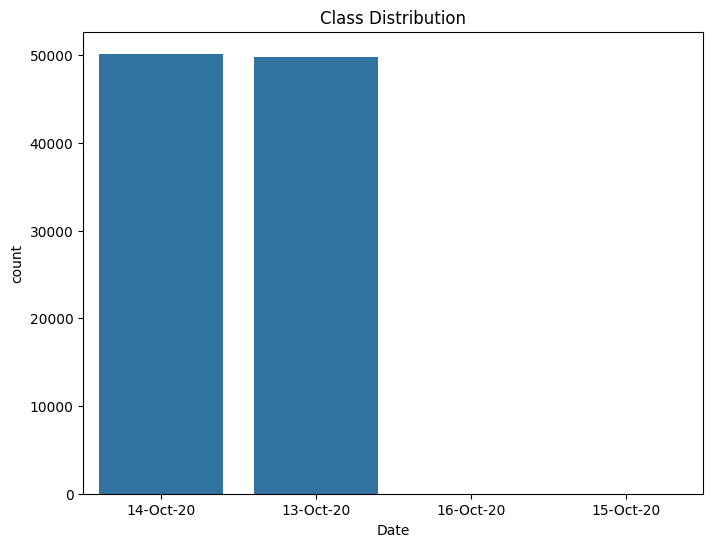

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("/content/CreditCardData.csv")

# Display the first few rows of the dataset
print(data.head())

# Check for class distribution (fraudulent vs. non-fraudulent transactions)
print(data['Date'].value_counts())

# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Date', data=data)
plt.title('Class Distribution')
plt.show()



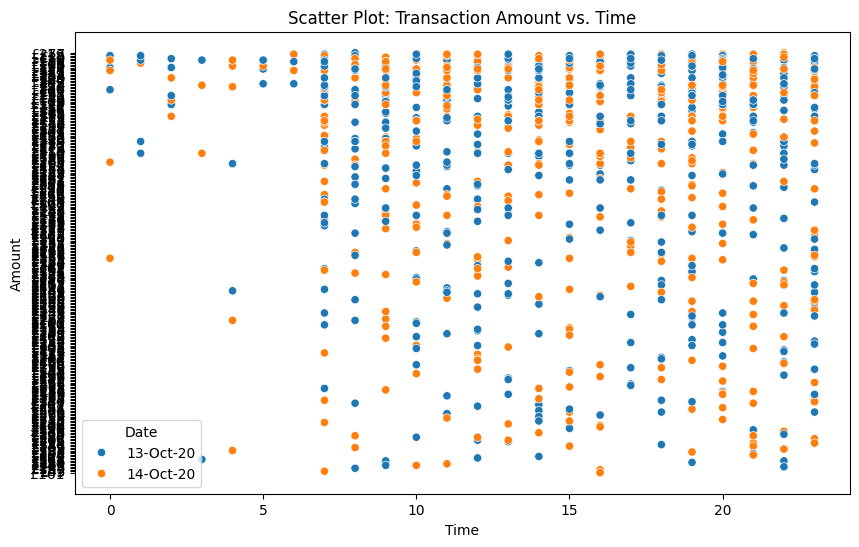

In [ ]:
sampled_data = data.sample(n=1000, random_state=42)

# Scatter plot of transaction amount vs. time, colored by class (fraudulent vs. non-fraudulent)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Amount', hue='Date', data=sampled_data)
plt.title('Scatter Plot: Transaction Amount vs. Time')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

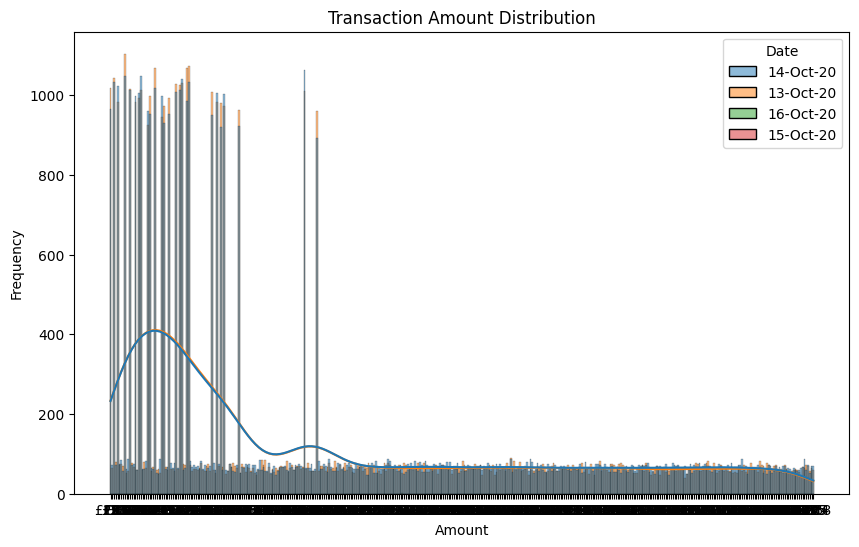

In [ ]:
# Visualize the transaction amount distribution for fraudulent and non-fraudulent transactions
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Amount', hue='Date', bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


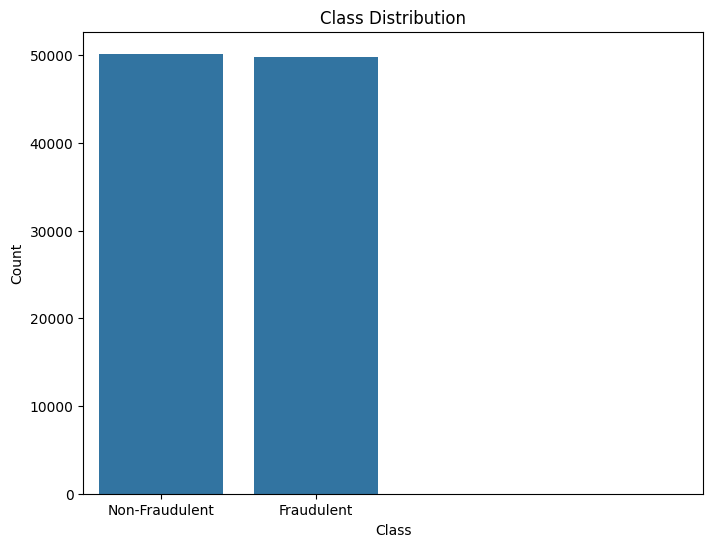

In [ ]:
class_counts = data['Date'].value_counts()

# Bar chart for class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(2), ['Non-Fraudulent', 'Fraudulent'])
plt.show()

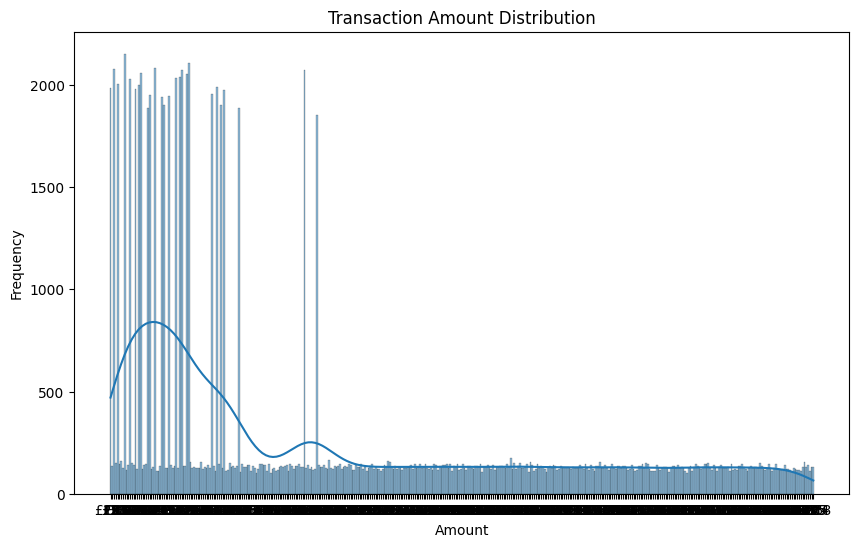

In [ ]:
# Histogram of transaction amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

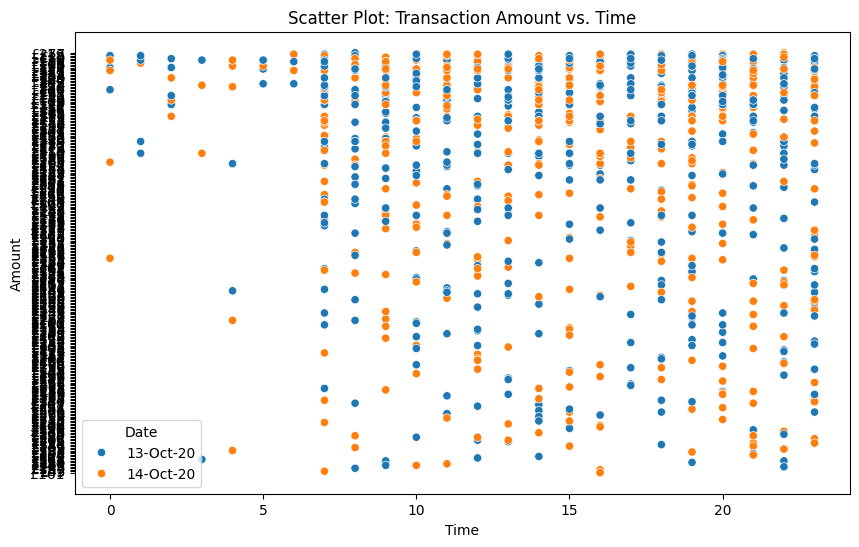

In [ ]:
# Sample only a subset of the data for scatter plot (to avoid overwhelming the plot)
sampled_data = data.sample(n=1000, random_state=42)

# Scatter plot of transaction amount vs. time, colored by class (fraudulent vs. non-fraudulent)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Amount', hue='Date', data=sampled_data)
plt.title('Scatter Plot: Transaction Amount vs. Time')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

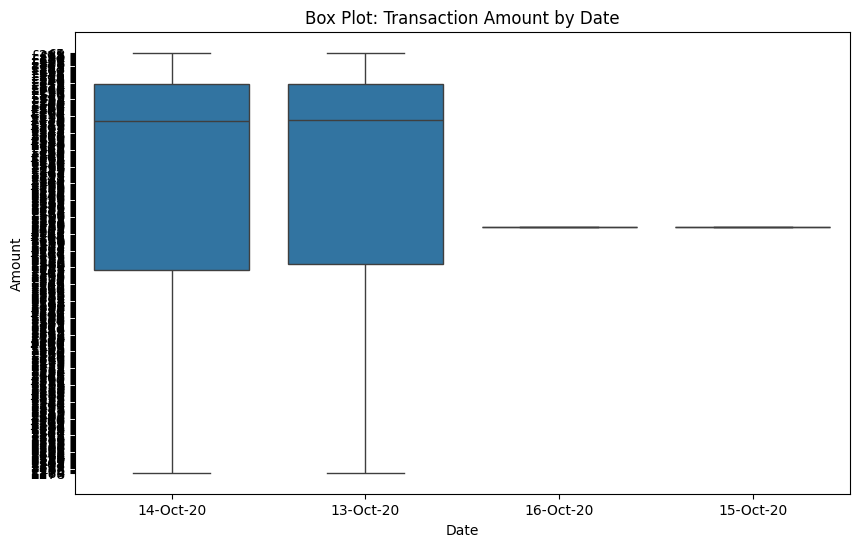

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Date', y='Amount', data=data)
plt.title('Box Plot: Transaction Amount by Date')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.show()

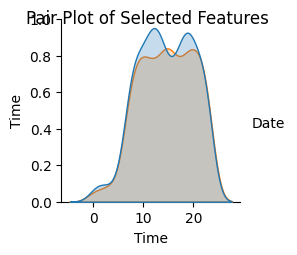

In [ ]:
features = ['Transaction ID','Date', 'Day of Week',  'Time', 'Type of Card', 'Entry Mode', 'Amount' ]

# Sample the data to reduce plotting time (optional)
sampled_data = data.sample(n=1000, random_state=42)

# Create pair plot
sns.pairplot(sampled_data[features], hue='Date', diag_kind='kde')
plt.suptitle('Pair Plot of Selected Features')
plt.show()

In [ ]:
import plotly.express as px

In [ ]:

sampled_data = data.sample(n=1000, random_state=42)

# Create an interactive scatter plot using Plotly
fig = px.scatter(sampled_data, x='Time', y='Amount')

fig.update_layout(title='Interactive Scatter Plot: Transaction Amount vs. Time',
                  xaxis_title='Time',
                  yaxis_title='Amount')
fig.show()

In [ ]:
%pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 52.9 MB/s eta 0:00:00


In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/CreditCardData.csv')  # Update with the actual filename

# Create the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("Credit Card Fraud Transaction Dashboard"),

    # Dropdown for selecting columns
    dcc.Dropdown(
        id='dropdown-column',
        options=[{'label': col, 'value': col} for col in df.columns],
        value='Amount'  # Default selection
    ),

    # Graph to display data
    dcc.Graph(id='graph')
])

# Define callback to update the graph based on dropdown selection
@app.callback(
    Output('graph', 'figure'),
    [Input('dropdown-column', 'value')]
)
def update_graph(selected_column):
    # Create a bar chart for the selected column
    data = [dict(
        type='histogram',
        x=df[selected_column],
        marker=dict(color='skyblue'),
        opacity=0.7
    )]

    layout = dict(
        title=f'Distribution of {selected_column}',
        xaxis=dict(title=selected_column),
        yaxis=dict(title='Count')
    )

    return dict(data=data, layout=layout)

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import plotly.express as px

# Load the dataset
df = pd.read_csv('/content/CreditCardData.csv')  # Update with the actual filename

# Function to generate histogram plot
def generate_histogram(column_name):
    fig = px.histogram(df, x=column_name, nbins=50, title=f'Histogram of {column_name}')
    fig.update_layout(xaxis_title=column_name, yaxis_title='Count')
    return fig

# Example: Generate histogram plot for 'Amount' column
histogram_figure = generate_histogram('Amount')

# Display the plot
histogram_figure.show()


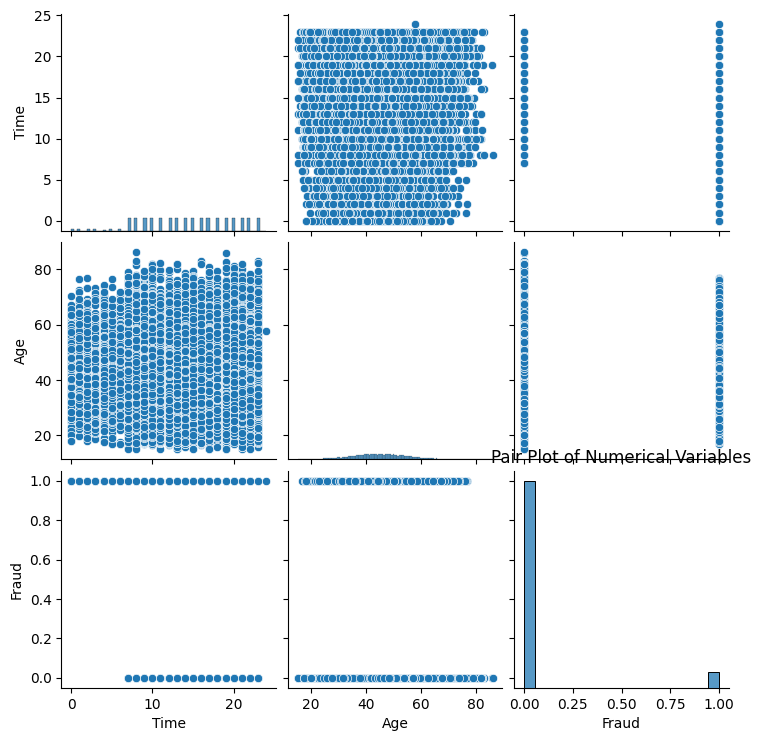

In [ ]:
sns.pairplot(data)
plt.title('Pair Plot of Numerical Variables')
plt.show()